In [128]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [129]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
from PIL import Image
from typing import Tuple

In [130]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [131]:

# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
   
    return image_dataset

In [132]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("macchine_nostre")
n_classes = 5 # class for segmentation
size_x = 256
size_y = 256

image_set = image_loader(img_folder,size_x,size_y) # real images...
image_dataset = np.array(image_set)

In [133]:
#Preparo il modello
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input
immagini = preprocess_input(image_dataset)

In [134]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "FPN_VGG16_256.hdf5")
loss = sm.losses.bce_jaccard_loss
model = load_model(path,compile = False) 


1/1 [==============================] - 1s 568ms/step


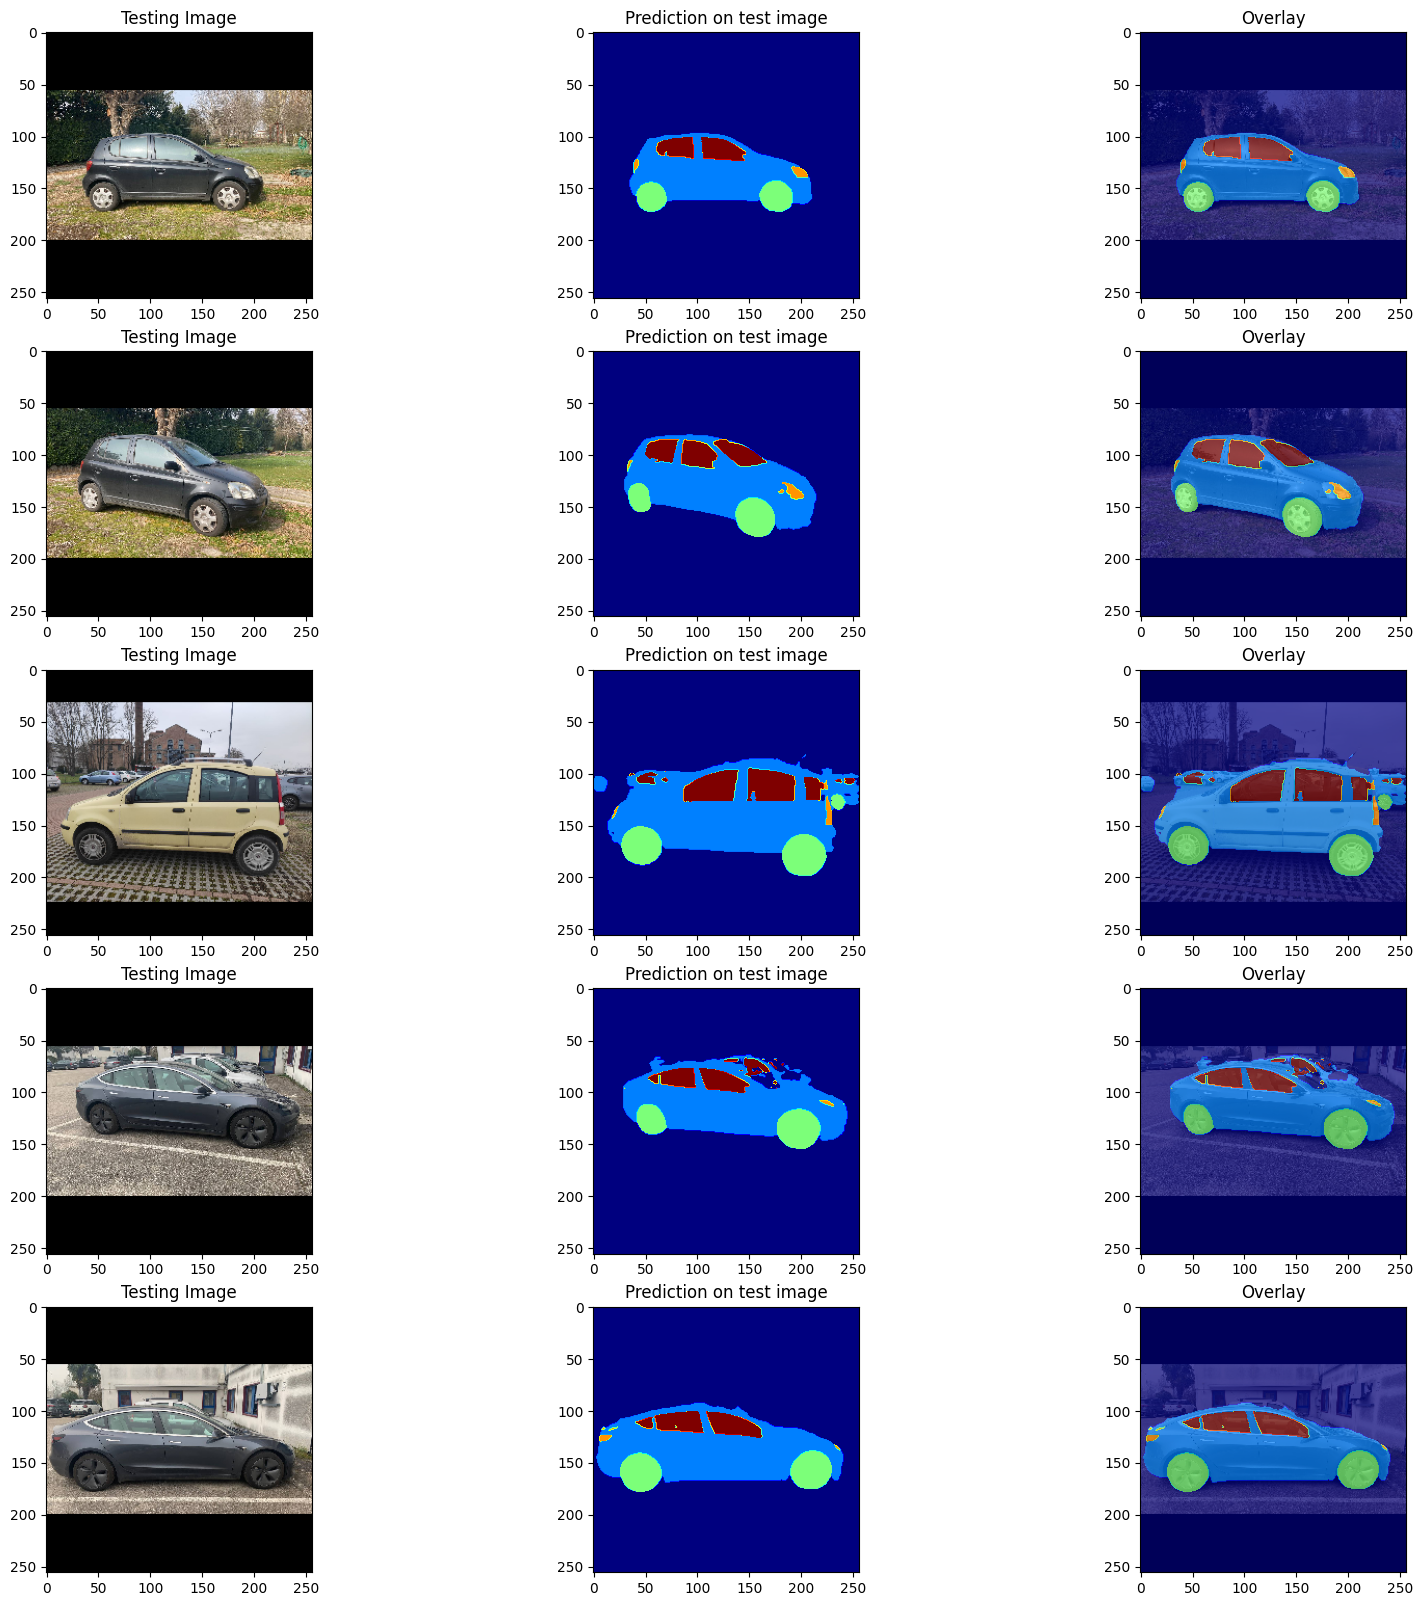

In [135]:
import random

fig = plt.figure(figsize=(20, 20))

for i in range(0,5):
    #Seleziono un'immagine da mostrare""
    img = image_dataset[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    test_img = immagini[i]
    test_img_input = np.expand_dims(test_img,0)
    prediction = (model.predict(test_img_input))
    
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 
    
    ax = fig.add_subplot(5,3,i*3+1)
    plt.title('Testing Image')
    plt.imshow(img)

    
    ax = fig.add_subplot(5,3,i*3+2)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    
    ax = fig.add_subplot(5,3,i*3+3)
    plt.title('Overlay')
    plt.imshow(img)
    plt.imshow(predicted_img, cmap='jet', alpha=0.7)
   